In [18]:
import math
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import *
import time

file_path = 'datos136.txt'

def read_data(file_path):
    nref = None
    vref = None
    vbase = None
    sbase = None
    tol = None
    vmin = None
    vmax = None
    zbase = None
    ramos = {}
    barras = {}
    datosRamas = False
    
    with open(file_path, 'r') as file:
    	for line in file:
        	line = line.strip()
        	if not line or line.startswith("%"):
        		continue
        	if nref == None:
        		nref=float(line[line.find("= ")+2:line.find(";")])
        	elif vref == None:
        		vref=float(line[line.find("= ")+2:line.find(";")])
        	elif vbase == None:
        		vbase=float(line[line.find("= ")+2:line.find(";")])
        	elif sbase == None:
        		sbase=float(line[line.find("= ")+2:line.find(";")])
        	elif tol == None:
        		tol=float(line[line.find("= ")+2:line.find(";")].replace("^", "e"))
        	elif vmin == None:
        		vmin=float(line[line.find("= ")+2:line.find(";")])
        	elif vmax == None:
        		vmax=float(line[line.find("= ")+2:line.find(";")])
        	elif zbase == None:
        		try:
        			zbase=float(line[line.find("= ")+2:line.find(";")])
        		except ValueError:
        			zbase=1000*((vbase**2)/sbase)
        	elif datosRamas == False:
        		if line.find("[")>-1:
        			l=line[line.find("[")+1:].split()
        			ramos[int(l[0]),int(l[1])]=[float(l[2]),float(l[3])]
        		elif line.find("]")>-1:
        			l=line.split()
        			ramos[int(l[0]),int(l[1])]=[float(l[2]),float(l[3])]
        			datosRamas = True
        		else:
        			l=line.split()
        			ramos[int(l[0]),int(l[1])]=[float(l[2]),float(l[3])]
        	else:
        		if line.find("[")>-1:
        			l=line[line.find("[")+1:].split()
        			barras[int(l[0])]=[float(l[1]),float(l[2]),float(l[3])]
        		else:
        			l=line.split()
        			barras[int(l[0])]=[float(l[1]),float(l[2]),float(l[3])]
        
    	data={
            "nref":nref,
            "vref":vref,
            "vbase":vbase,
            "sbase":sbase,
            "tol":tol,
            "vmin":vmin,
            "vmax":vmax,
            "zbase":zbase,
            "ramos":ramos,
            "barras":barras
        }

    	return data


In [19]:
d=read_data(file_path)

nref = d['nref']
vref = d['vref']
vbase = d['vbase']
sbase = d['sbase']
tol = d['tol']
vmin = d['vmin']
vmax = d['vmax']
zbase = d['zbase']


R = {}
X = {}
Z = {}
B1 = []
B = []
B2 = []

for (i,j) in d['ramos']:
    if j==nref:
        R[j,i]=d['ramos'][i,j][0]/zbase
        X[j,i]=d['ramos'][i,j][1]/zbase
        Z[j,i]=math.sqrt(R[j,i]**2+X[j,i]**2)
        B.append((j,i))
        B1.append((j,i))
    else:
        R[i,j]=d['ramos'][i,j][0]/zbase
        X[i,j]=d['ramos'][i,j][1]/zbase
        Z[i,j]=math.sqrt(R[i,j]**2+X[i,j]**2)
        B1.append((i,j))
        B.append((i,j))
        if i!=nref:
            B1.append((j,i))
            B2.append((j,i))
            R[j,i]=d['ramos'][i,j][0]/zbase
            X[j,i]=d['ramos'][i,j][1]/zbase
            Z[j,i]=math.sqrt(R[i,j]**2+X[i,j]**2)

Pd = {}
Qd = {}
Qbc = {}
N = []

for i in d['barras']:
    Pd[i]=d['barras'][i][0]
    Qd[i]=d['barras'][i][1]
    Qbc[i]=d['barras'][i][2]
    N.append(i)
    

G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(B)

def generar_pos(G):

    roots = {n:(d,list(G.successors(n))) for n,d in G.in_degree()}
    t=len(roots)

    nivel={}
    while len(nivel)<len(roots):
        for n in roots:
            if roots[n][0]==0:
                nivel[n]=t
                for s in roots[n][1]:
                    nivel[s]=nivel[n]-1
            if n in list(nivel.keys()):
                l=nivel[n]
                for s in roots[n][1]:
                    nivel[s]=l-1
    minimo=min(nivel.values())               
    for n in nivel:
        nivel[n]-=minimo

    maximo=max(nivel.values())
    i=0
    nivelc={}
    while i<=maximo:
        cont=0
        for n in nivel:
            if nivel[n]==i:
                nivelc[n]=cont
                cont+=1
        i+=1

    pos={n:(nivelc[n],nivel[n]) for n in nivel}
    return pos
'''
if file_path != 'datos14.txt' :
    pos = generar_pos(G)
    fig, ax = plt.subplots(figsize=(15, 10))
    #fig, ax = plt.subplots(figsize=(20, 30))
    nx.draw(G, pos=pos, with_labels=True, node_size=100, node_color="skyblue",font_size=9)
    plt.show()
else:
    pos = generar_pos(G)
    nx.draw(G, pos=pos, with_labels=True, node_size=1000, node_color="skyblue")
    plt.show()
'''    
    
M=100000
Imax = 800

316.8568653203306  1.2169575691223145 s
315.82012581702213  1.8693914413452148 s
313.74583726992034  2.3810160160064697 s
313.7457558542507  3.0568788051605225 s
313.02463779758307  3.9801015853881836 s
312.74549179701194  5.009448528289795 s
312.68641913337694  7.19618821144104 s
312.59164138004314  7.787317514419556 s
312.27263269695356  13.223761558532715 s
312.2725798300033  16.076337575912476 s
297.779713917732  20.910444259643555 s
285.6645937461076  22.122746467590332 s
284.77120274140725  22.62296199798584 s
284.30375849141444  23.950907230377197 s
282.5706648185396  26.312804460525513 s
280.83140944807434  30.937926054000854 s
280.4937817294674  36.3226432800293 s
280.4937510127914  42.279218912124634 s
280.08576499725837  44.86760997772217 s
279.616643752725  50.755839586257935 s
279.42597857392656  57.08814358711243 s
Tiempo Corrida = 64.77945518493652 s


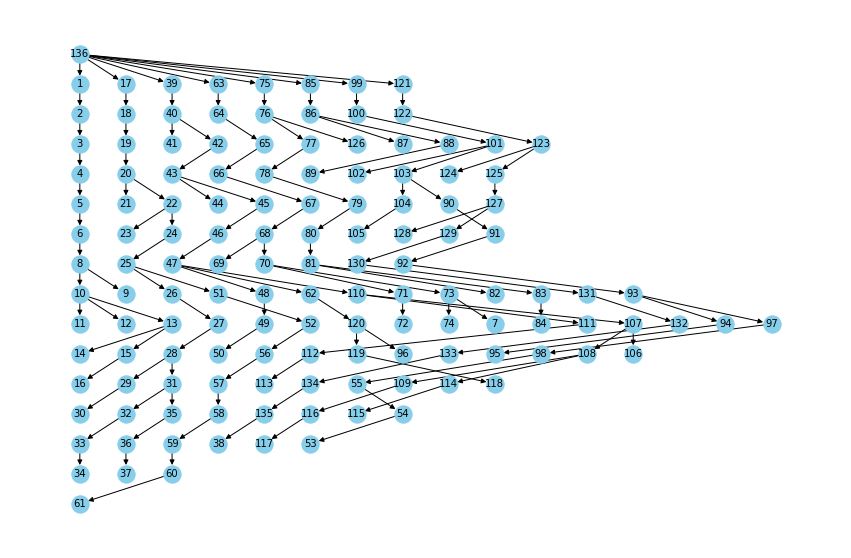

In [20]:
#GENERAR ARBOR INICIAL CON EL SIGUIENTE MODELO RELAJADO
def relax():
    m = Model("RSD_relax")
    m.setParam('OutputFlag',0)
    m.setParam('NonConvex', 2)
    # Configurar para encontrar la primera solución factible
    #m.setParam('PoolSearchMode', 1)  # 1 significa encontrar la primera solución factible
    #m.setParam('PoolSolutions', 1)  # Número de soluciones factibles a encontrar antes de detenerse
    y = m.addVars(B, vtype = GRB.BINARY , name="y")
    delta = m.addVars(B, name="delta")
    P = m.addVars(B, name="P",lb=0)
    Q = m.addVars(B, name="Q",lb=0)
    Ps = m.addVar(name="Ps")
    Qs = m.addVar(name="Qs")
    Vsqrt = m.addVars(N, name="V^2",lb=vmin**2,ub=vmax**2)
    Isqrt = m.addVars(B, name="I^2")
    m.setObjective(sum(R[i, j] * Isqrt[i, j] for i, j in B), GRB.MINIMIZE)
    for i in N:
        if i == nref:
            m.addConstr(Ps-P.sum(i,"*")>=-sum(R[k,j]*Isqrt[k,j] for k,j in B if k == i))
            m.addConstr(Qs-Q.sum(i,"*")>=-sum(X[k,j]*Isqrt[k,j] for k,j in B if k == i))
        else:
            m.addConstr(P.sum(i,"*") - P.sum("*",i) <= -Pd[i]/sbase - sum(R[k,j]*Isqrt[k,j] for k,j in B if k == i))
            m.addConstr(Q.sum(i,"*") - Q.sum("*",i) <= -Qd[i]/sbase - sum(X[k,j]*Isqrt[k,j] for k,j in B if k == i))
    for i,j in B:
        m.addConstr(Isqrt[i,j]<=Imax**2*y[i,j])
        m.addConstr(Vsqrt[i] >= Vsqrt[j] + 2*(R[i,j]*P[i,j]+X[i,j]*Q[i,j]) - Z[i,j]**2*Isqrt[i,j] + delta[i,j] )
        m.addConstr( Vsqrt[j]*Isqrt[i,j] >= (P[i,j]**2 + Q[i,j]**2) )
        m.addConstr(-vmax**2*(1-y[i,j]) <= delta[i,j])
        m.addConstr( vmax**2*(1-y[i,j]) >= delta[i,j])
        m.addConstr(P[i,j]<=y[i,j]*M)
        m.addConstr(Q[i,j]<=y[i,j]*M)
        if i!=nref:
            m.addConstr(y.sum('*',i)==1)
    m.addConstr(Vsqrt[nref] == vref**2 )
    m.addConstr(sum(y[i,j] for i,j in B)==len(N)-1)
    m.optimize()
    y_init = {}
    for edge in B:
        y_init[edge]=y[edge].x
    return y_init

def constructivo():
    m = Model("RSD_relax")
    m.setParam('OutputFlag',0)
    m.setParam('NonConvex', 2)
    y = m.addVars(B, vtype = GRB.BINARY , name="y")
    delta = m.addVars(B, name="delta")
    P = m.addVars(B, name="P",lb=0)
    Q = m.addVars(B, name="Q",lb=0)
    Ps = m.addVar(name="Ps")
    Qs = m.addVar(name="Qs")
    Vsqrt = m.addVars(N, name="V^2",lb=vmin**2,ub=vmax**2)
    Isqrt = m.addVars(B, name="I^2")
    m.setObjective(sum(R[i, j] * Isqrt[i, j] for i, j in B), GRB.MINIMIZE)
    for i in N:
        if i == nref:
            m.addConstr(Ps-P.sum(i,"*")==-sum(R[k,j]*Isqrt[k,j] for k,j in B if k == i))
            m.addConstr(Qs-Q.sum(i,"*")==-sum(X[k,j]*Isqrt[k,j] for k,j in B if k == i))
        else:
            m.addConstr(P.sum(i,"*") - P.sum("*",i) == -Pd[i]/sbase - sum(R[k,j]*Isqrt[k,j] for k,j in B if k == i))
            m.addConstr(Q.sum(i,"*") - Q.sum("*",i) == -Qd[i]/sbase - sum(X[k,j]*Isqrt[k,j] for k,j in B if k == i))
    for i,j in B:
        m.addConstr(Isqrt[i,j]<=Imax**2*y[i,j])
        m.addConstr(Vsqrt[i] >= Vsqrt[j] + 2*(R[i,j]*P[i,j]+X[i,j]*Q[i,j]) - Z[i,j]**2*Isqrt[i,j] + delta[i,j] )
        m.addConstr( Vsqrt[j]*Isqrt[i,j] >= (P[i,j]**2 + Q[i,j]**2) )
        m.addConstr(-vmax**2*(1-y[i,j]) <= delta[i,j])
        m.addConstr( vmax**2*(1-y[i,j]) >= delta[i,j])
        m.addConstr(P[i,j]<=y[i,j]*M)
        m.addConstr(Q[i,j]<=y[i,j]*M)
        if i!=nref:
            m.addConstr(y.sum('*',i)==1)
            m.addConstr(Vsqrt[nref] == vref**2 )
            m.addConstr(sum(y[i,j] for i,j in B)==len(N)-1)
    m.optimize()

    Arcos = []
    Inactivos = []
    for edge in B1:
        if edge in B:
            if y[edge].x==1:
                Arcos.append(edge)
            else:
                Inactivos.append(edge)
        else:
            Inactivos.append(edge)

    G = nx.DiGraph()
    G.add_nodes_from(N)
    G.add_edges_from(Arcos)

    V={i:1 for i in N}
    I={(i,j):0 for i,j in B}
    p={(i,j):P[i,j].x for i,j in B}
    q={(i,j):Q[i,j].x for i,j in B}

    hijos = [(nref,h) for h in G.neighbors(nref)]
    factible=True
    while len(hijos)>0:
        nuevos=[]
        reiniciar=False
        for h in hijos:
            if reiniciar==False:
                m1 = Model("Sistema Ecuaciones")
                m1.setParam('OutputFlag',0)
                m1.setParam('NonConvex', 2)
                voltaje = m1.addVar(name="V^2")
                corriente = m1.addVar(name="I^2")
                m1.addConstr(voltaje-corriente*Z[h]**2-V[h[0]]+2*(R[h]*p[h]+X[h]*q[h])==0)
                m1.addConstr(corriente*voltaje==(p[h]**2 + q[h]**2))
                m1.optimize()
                if m1.status==GRB.OPTIMAL:
                    V[h[1]]=voltaje.x
                    I[h]=corriente.x
                    nhijos=[(h[1],n) for n in G.neighbors(h[1])]
                    for nhijo in nhijos:
                        nuevos.append(nhijo)
                    if voltaje.x<vmin**2:
                        Cor=corriente.x
                        Vol=voltaje.x
                        m.addConstr(Vsqrt[j]>=Vol+0.01)
                        m.optimize()
                        if m.status==GRB.OPTIMAL:
                            p={(i,j):P[i,j].x for i,j in B}
                            q={(i,j):Q[i,j].x for i,j in B}
                            V={i:1 for i in N}
                            I={(i,j):0 for i,j in B}
                            hijos = [(nref,h) for h in G.neighbors(nref)]
                            factible=True
                            reiniciar=True
                        else:
                            print(h,"infactible")
                            factible=False
                else:
                    print(h,"infactible")
                    factible=False
        if factible == True and reiniciar == False:
            hijos=nuevos
        elif reiniciar == False:
            hijos=[]
    return sum(I[i,j]*R[i,j] for i,j in B),p,q,V,I,Arcos

def evaluar(Arcos):
    m = Model("RSD")
    m.setParam('OutputFlag',0) 
    m.setParam('NonConvex', 2)
    P = m.addVars(Arcos, name="P",lb=0)
    Q = m.addVars(Arcos, name="Q",lb=0)
    Ps = m.addVar(name="Ps")
    Qs = m.addVar(name="Qs")
    Vsqrt = m.addVars(N, name="V^2",lb=vmin**2,ub=vmax**2)
    Isqrt = m.addVars(Arcos, name="I^2",ub=Imax**2)
    m.setObjective(sum(R[i, j] * Isqrt[i, j] for i, j in Arcos), GRB.MINIMIZE)
    for i in N:
        if i == nref:
            m.addConstr(Ps-P.sum(i,"*")==-sum(R[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
            m.addConstr(Qs-Q.sum(i,"*")==-sum(X[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
        else:
            m.addConstr(P.sum(i,"*") - P.sum("*",i) == -Pd[i]/sbase - sum(R[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
            m.addConstr(Q.sum(i,"*") - Q.sum("*",i) == -Qd[i]/sbase - sum(X[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
    for i,j in Arcos:
        m.addConstr(Vsqrt[i] >= Vsqrt[j] + 2*(R[i,j]*P[i,j]+X[i,j]*Q[i,j]) - Z[i,j]**2*Isqrt[i,j] )
        m.addConstr( Vsqrt[j]*Isqrt[i,j] >= (P[i,j]**2 + Q[i,j]**2) )
    m.addConstr(Vsqrt[nref] == vref**2 ) 
    m.optimize()
    
    G = nx.DiGraph()
    G.add_nodes_from(N)
    G.add_edges_from(Arcos)
    V={i:1 for i in N}
    I={(i,j):0 for i,j in Arcos}
    p={(i,j):P[i,j].x for i,j in Arcos}
    q={(i,j):Q[i,j].x for i,j in Arcos}
    hijos = [(nref,h) for h in G.neighbors(nref)]
    factible=True
    while len(hijos)>0:
        nuevos=[]
        for h in hijos:
            m1 = Model("Sistema Ecuaciones")
            m1.setParam('OutputFlag',0)
            m1.setParam('NonConvex', 2)
            voltaje = m1.addVar(name="V^2")
            corriente = m1.addVar(name="I^2")
            m1.addConstr(voltaje-corriente*Z[h]**2-V[h[0]]+2*(R[h]*p[h]+X[h]*q[h])==0)
            m1.addConstr(corriente*voltaje==(p[h]**2 + q[h]**2))
            m1.optimize()
            if m1.status==GRB.OPTIMAL:
                V[h[1]]=voltaje.x
                I[h]=corriente.x
                nhijos=[(h[1],n) for n in G.neighbors(h[1])]
                for nhijo in nhijos:
                    nuevos.append(nhijo)
            else:
                print(h,"infactible")
                factible=False
        if factible == True:
            hijos=nuevos
        else:
            hijos=[]
    return sum(I[i,j]*R[i,j] for i,j in Arcos),p,q,V,I,Arcos
    
def evaluar2(Arcos):
    m = Model("RSD")
    m.setParam('OutputFlag',0) 
    m.setParam('NonConvex', 2)
    P = m.addVars(Arcos, name="P",lb=0)
    Q = m.addVars(Arcos, name="Q",lb=0)
    Ps = m.addVar(name="Ps")
    Qs = m.addVar(name="Qs")
    Vsqrt = m.addVars(N, name="V^2",lb=vmin**2,ub=vmax**2)
    Isqrt = m.addVars(Arcos, name="I^2",ub=Imax**2)
    m.setObjective(sum(R[i, j] * Isqrt[i, j] for i, j in Arcos), GRB.MINIMIZE)
    for i in N:
        if i == nref:
            m.addConstr(Ps-P.sum(i,"*")==-sum(R[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
            m.addConstr(Qs-Q.sum(i,"*")==-sum(X[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
        else:
            m.addConstr(P.sum(i,"*") - P.sum("*",i) == -Pd[i]/sbase - sum(R[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
            m.addConstr(Q.sum(i,"*") - Q.sum("*",i) == -Qd[i]/sbase - sum(X[k,j]*Isqrt[k,j] for k,j in Arcos if k == i))
    for i,j in Arcos:
        m.addConstr(Vsqrt[i] == Vsqrt[j] + 2*(R[i,j]*P[i,j]+X[i,j]*Q[i,j]) - Z[i,j]**2*Isqrt[i,j] )
        m.addConstr( Vsqrt[j]*Isqrt[i,j] == (P[i,j]**2 + Q[i,j]**2) )
    m.addConstr(Vsqrt[nref] == vref**2 ) 
    m.optimize()
    if m.Status == GRB.OPTIMAL: 
        p = {}
        q = {}
        v = {}
        I = {}
        ps = Ps.x
        qs = Qs.x
        obj=m.objval
        for edge in Arcos:
            p[edge]=P[edge].x
            q[edge]=Q[edge].x
            I[edge]=Isqrt[edge].x
        for i in N:
            v[i]=Vsqrt[i].x
        for edge in Inactivos:
            p[edge]=0
            q[edge]=0
            I[edge]=0 
        return obj,p,q,v,I,ps,qs
    else:
        return -1,-1

def is_cycle_free(graph, edge_to_add, Arcs):
    temp_graph = graph.copy()
    temp_graph.add_edge(*edge_to_add)
    cycle_edges = list(nx.find_cycle(temp_graph, orientation='original'))
    quitar=0
    for i,j,t in cycle_edges:
        if edge_to_add[1]==j and (i,j) in Arcs:
            quitar=(i,j)
        elif edge_to_add[1]== i and (j,i) in Arcs:
            quitar=(j,i)
    return False, quitar

def visualize_tree(graph):
    pos = generar_pos(graph)
    fig, ax = plt.subplots(figsize=(15, 10))
    nx.draw(G, pos=pos, with_labels=True, node_size=300, node_color="skyblue",font_size=10)
    plt.show()


inicio = time.time()
    
Arcos = []
Inactivos = []
y_init = relax()
for edge in B1:
    if edge in B:
        if y_init[edge]==1:
            Arcos.append(edge)
        else:
            Inactivos.append(edge)
    else:
        Inactivos.append(edge)

best=evaluar2(Arcos)

if best[0]==-1:
    best=constructivo()
    Arcos = best[5]

Inactivos = []
for edge in B1:
    if edge in B:
        if edge not in Arcos:
            Inactivos.append(edge)
    else:
        Inactivos.append(edge)

G = nx.Graph()
G.add_nodes_from(N)
G.add_edges_from(Arcos)

print(best[0]*sbase, f' {time.time()-inicio} s')
mejoro=True
while mejoro == True:
    mejoro=False
    for i,j in Inactivos:
        if (j,i) not in Arcos and mejoro==False:
            ciclo=is_cycle_free(G,(i,j),Arcos)
            if ciclo[0]==False and ciclo[1]!=0:
                Arcos_test=Arcos.copy()
                Arcos_test.append((i,j))
                Arcos_test.remove(ciclo[1])
                nfac=evaluar2(Arcos_test)
                if nfac[0]<best[0] and nfac[0]!=-1:
                    Arcos.append((i,j))
                    Arcos.remove(ciclo[1])
                    Inactivos.remove((i,j))
                    Inactivos.append(ciclo[1])
                    best=nfac
                    G.remove_edge(ciclo[1][0], ciclo[1][1])
                    G.add_edge(i,j)
                    mejoro=True
                    print(best[0]*sbase, f' {time.time()-inicio} s')
                    break
                    
print(f'Tiempo Corrida = {time.time()-inicio} s')                 
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(Arcos)

visualize_tree(G)
